In [68]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [70]:
df = pd.read_excel('fotball_data_for_project.xlsx')

## Обработка и очистка данных

In [73]:
# Удаляем строки, где в колонке 'Not need' значение не NaN
df = df[df['Not need'].isna()]
# Сбрасываем индексы, если нужно
df.reset_index(drop=True, inplace=True)

# Удаляем колонку Not need
df = df.drop('Not need', axis=1)

# Выбираем все числовые колонки, кроме 'Goals per match'
numeric_columns = df.select_dtypes(include=['float', 'int']).columns
columns_to_round = [col for col in numeric_columns if col != 'Goals per match']
# Применяем округление к нужным колонкам
df[columns_to_round] = df[columns_to_round].astype(int)

# Увеличиваем индекс на 1
df.index += 1

### Анализ самых результативных игроков

В этой визуализации мы хотим определить 10 футболистов с наибольшим количеством забитых голов в сезоне. Это позволит выявить ключевых нападающих и сопоставить их результативность.


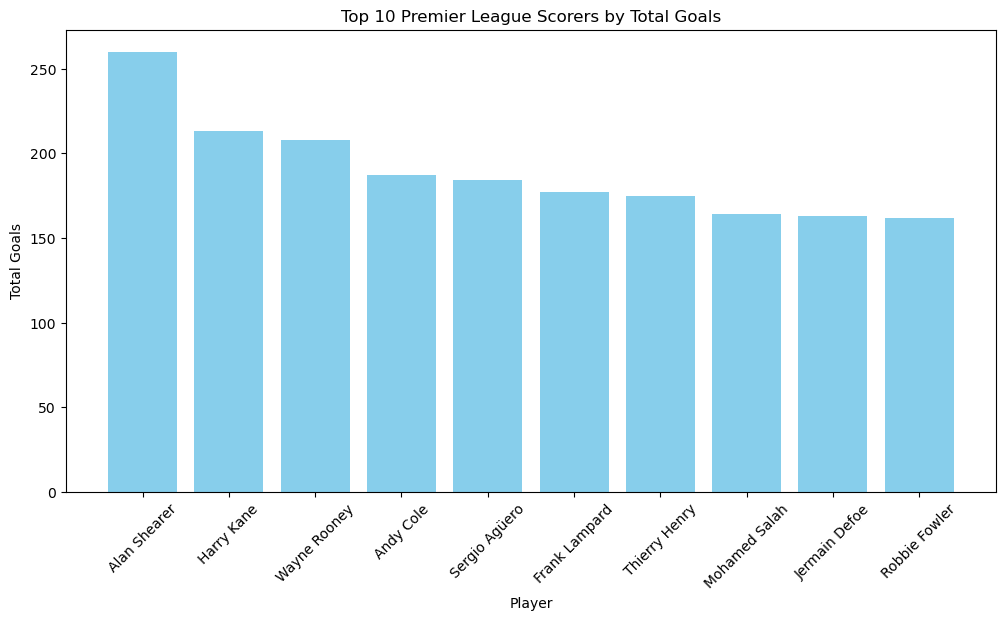

In [76]:
top_10 = df.sort_values(by='Total goals', ascending=False).head(10)
plt.figure(figsize=(12, 6))
plt.bar(top_10["Player"], top_10["Total goals"], color='skyblue')
plt.xlabel("Player")
plt.ylabel("Total Goals")
plt.title("Top 10 Premier League Scorers by Total Goals")
plt.xticks(rotation=45)
plt.show()

### Влияние национальности на результативность

Здесь мы анализируем, какие страны представлены наиболее результативными игроками в лиге. Это может дать представление о географических очагах футбольного таланта.


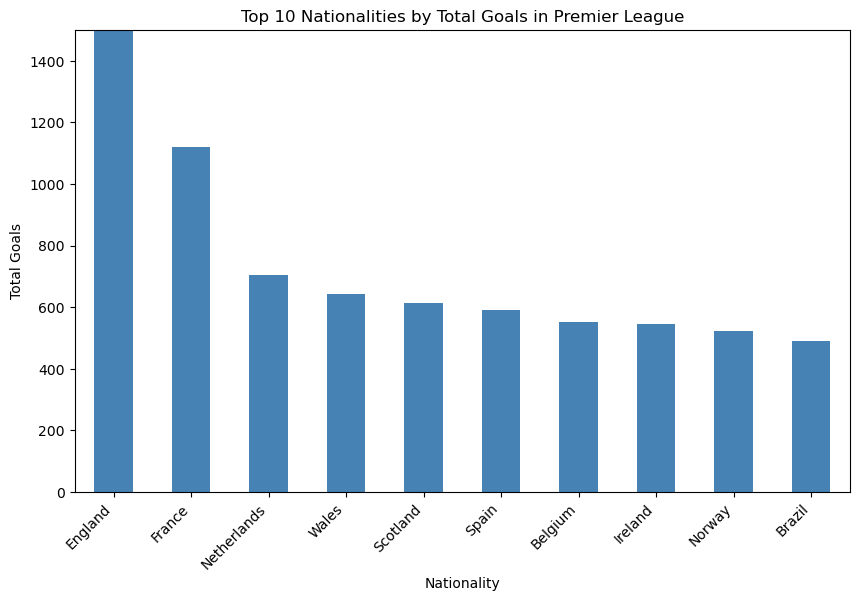

In [11]:
# Очистка столбца Nationality
df['Nationality'] = df['Nationality'].str.strip().str.lower().str.capitalize()

# Проверка количества по нациям после очистки
nationality_counts = df['Nationality'].value_counts().head(15)
nationality_counts

total_goals_by_country = df.groupby('Nationality')['Total goals'].sum().sort_values(ascending=False).head(10)

plt.figure(figsize=(10, 6))
total_goals_by_country.plot(kind='bar', color='steelblue')
plt.xlabel('Nationality')
plt.ylabel('Total Goals')
plt.ylim(0, 1500)
plt.title('Top 10 Nationalities by Total Goals in Premier League')
plt.xticks(rotation=45, ha='right')
plt.show()

### Распределение игроков по позициям

Перед тем как анализировать эффективность, важно понять структуру данных: сколько игроков играет на каждой из позиций (нападающий, полузащитник и т.д.).


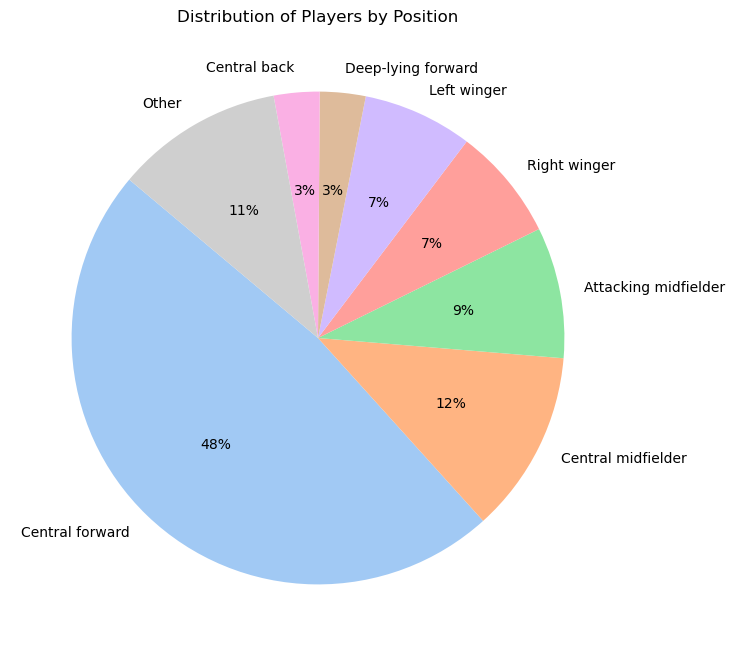

In [60]:

position_counts = df['Position'].value_counts()

position_counts.index = position_counts.index.str.strip().str.lower().str.capitalize()

position_counts['Central forward'] = position_counts.get('Central forward', 0) + position_counts.get('Central forward ', 0)
position_counts['Central midfielder'] = position_counts.get('Central midfielder', 0) + position_counts.get('Central midfielder ', 0)
position_counts = position_counts.drop(['Central forward ', 'Central midfielder '], errors='ignore')
position_counts = position_counts.sort_values(ascending=False)
median_count = position_counts.median()
top_positions = position_counts[position_counts >= median_count]
other_positions = position_counts[position_counts < median_count].sum()
position_counts_filtered = top_positions.copy()
position_counts_filtered['other'] = other_positions

# Построение круговой диаграммы
plt.figure(figsize=(8, 8))
plt.pie(
    position_counts_filtered,
    labels=position_counts_filtered.index.str.capitalize(),
    autopct=lambda p: f'{int(round(p))}%',
    startangle=140,
    colors=sns.color_palette('pastel', len(position_counts_filtered))
)
plt.title('Distribution of Players by Position')
plt.show()


### Группировка позиций в укрупнённые категории

Для упрощения последующего анализа мы сгруппировали все позиции в 4 основные роли: нападающие, полузащитники, защитники, вратари. Это поможет понять вклад каждой группы.


[]
          Player            Position      Category
1   Alan Shearer     Central Forward    Нападающий
2     Harry Kane     Central Forward    Нападающий
3   Wayne Rooney     Central Forward    Нападающий
4      Andy Cole     Central Forward    Нападающий
5  Sergio Agüero     Central Forward    Нападающий
6  Frank Lampard  Central Midfielder  Полузащитник
7  Thierry Henry     Central Forward    Нападающий


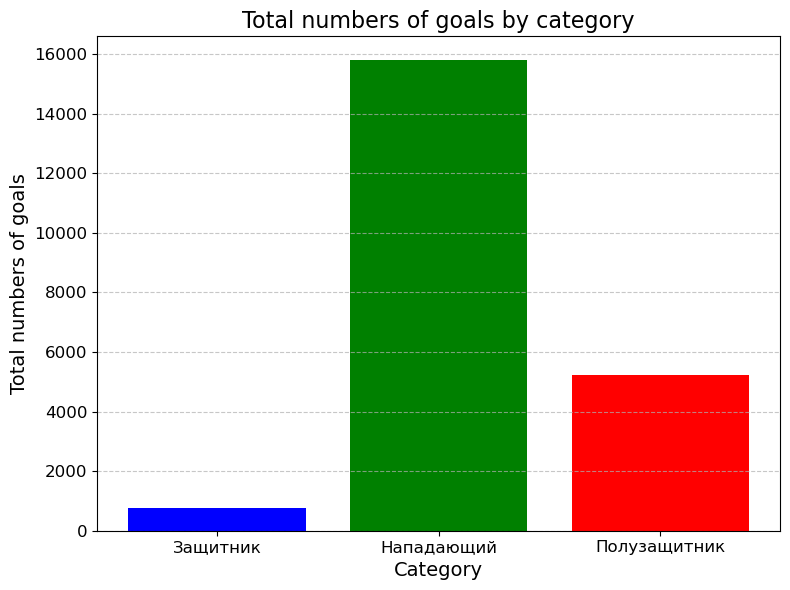

In [50]:
# Приводим позиции к единому виду
df['Position'] = df['Position'].str.strip().str.title()

# Создаем словарь для распределения позиций
position_mapping = {
    'Central Forward': 'Нападающий',
    'Left Winger': 'Нападающий',
    'Right Winger': 'Нападающий',
    'Deep-Lying Forward': 'Нападающий',
    'Attacking Midfielder': 'Полузащитник',
    'Central Midfielder': 'Полузащитник',
    'Defensive Midfielder': 'Полузащитник',
    'Right Midfielder': 'Полузащитник',
    'Left Midfielder': 'Полузащитник',
    'Central Back': 'Защитник',
    'Left Back': 'Защитник',
    'Right Back': 'Защитник'
}

df['Category'] = df['Position'].map(position_mapping)


print(df[df['Category'].isna()]['Position'].unique())

df['Category'] = df['Category'].fillna('Другие')
print(df[['Player', 'Position', 'Category']].head(7))

category_goals = df.groupby('Category')['Total goals'].sum().reset_index()

# Построение гистограммы
plt.figure(figsize=(8, 6))
plt.bar(category_goals['Category'], category_goals['Total goals'], color=['blue', 'green', 'red'])
plt.title('Total numbers of goals by category', fontsize=16)
plt.xlabel('Category', fontsize=14)
plt.ylabel('Total numbers of goals', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# Отображение графика
plt.show()

### Кастеризация результативности клубов

С помощью KMeans-кластеризации мы выделяем группы клубов по уровню результативности игроков. Это помогает увидеть, какие клубы ассоциируются с высокой или низкой результативностью.

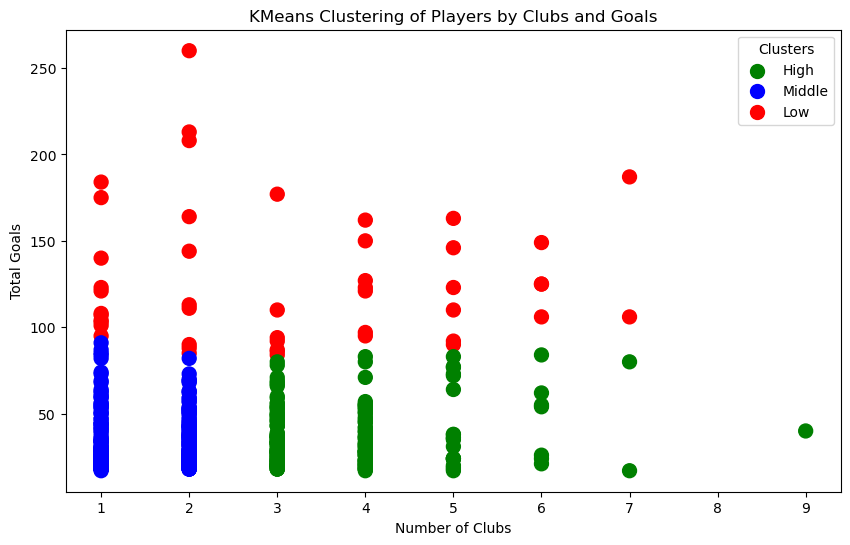

In [52]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Масштабирование данных
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df[['Clubs', 'Total goals']])

# Кластеризация с помощью KMeans
kmeans = KMeans(n_clusters=3, random_state=0)
df['Cluster'] = kmeans.fit_predict(scaled_features)
colors = {0: 'blue', 1: 'green', 2: 'red'}
cluster_labels = {0: 'Middle', 1: 'High', 2: 'Low'}

plt.figure(figsize=(10, 6))
plt.scatter(df['Clubs'], df['Total goals'], c=df['Cluster'].map(colors), s=100)

plt.scatter([], [], c='green', label='High', s=100)
plt.scatter([], [], c='blue', label='Middle', s=100)
plt.scatter([], [], c='red', label='Low', s=100)
plt.legend(loc='upper right', title="Clusters")

plt.xlabel('Number of Clubs')
plt.ylabel('Total Goals')
plt.title('KMeans Clustering of Players by Clubs and Goals')
plt.show()


### Эффективность игроков: нормализация по времени

Чтобы сравнивать игроков с разным временем на поле, мы рассчитываем эффективность как количество голов на 1000 минут. Затем визуализируем связь между временем и результативностью.


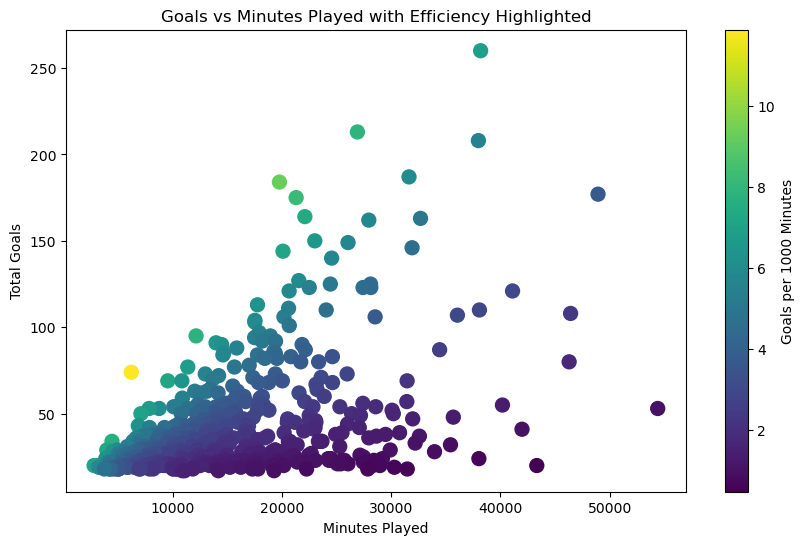

In [56]:

# Создаем столбец для эффективности: голов на 1000 минут
df['Goals per 1000 Minutes'] = (df['Total goals'] / df['Minutes']) * 1000

# Диаграмма рассеяния голов по минутам
plt.figure(figsize=(10, 6))
plt.scatter(df['Minutes'], df['Total goals'], c=df['Goals per 1000 Minutes'], cmap='viridis', s=100)
plt.colorbar(label='Goals per 1000 Minutes')
plt.xlabel('Minutes Played')
plt.ylabel('Total Goals')
plt.title('Goals vs Minutes Played with Efficiency Highlighted')
plt.show()

### Зависимость эффективности от числа матчей

Здесь мы проверяем, есть ли взаимосвязь между количеством сыгранных матчей и результативностью (голы + ассисты на матч). Используем корреляционный анализ.


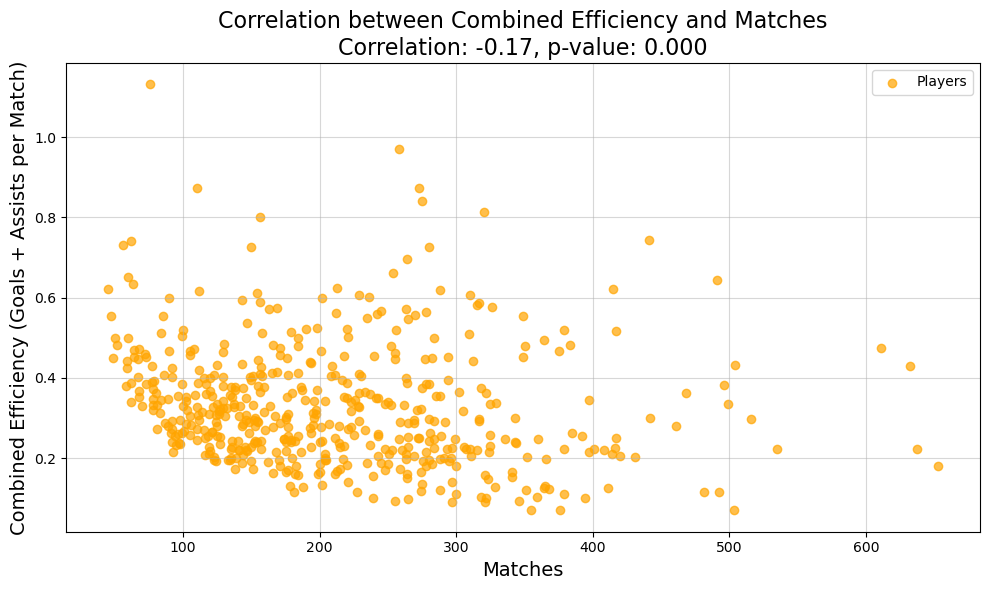

Корреляция между эффективностью и матчами: -0.17064704663986346
P-value: 0.00012587430542299898


In [63]:
from scipy.stats import pearsonr

# Рассчитываем эффективность: (Голы + Ассисты) / Матчи
df['Combined Efficiency'] = (df['Total goals'] + df['Assists']) / df['Matches']

# Вычисляем корреляцию и p-value между эффективностью и количеством матчей
correlation, p_value = pearsonr(df['Combined Efficiency'], df['Matches'])

# Визуализация
plt.figure(figsize=(10, 6))
plt.scatter(df['Matches'], df['Combined Efficiency'], color='orange', alpha=0.7, label='Players')
plt.title(f'Correlation between Combined Efficiency and Matches\nCorrelation: {correlation:.2f}, p-value: {p_value:.3f}', fontsize=16)
plt.xlabel('Matches', fontsize=14)
plt.ylabel('Combined Efficiency (Goals + Assists per Match)', fontsize=14)
plt.grid(alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

# Вывод результата
print("Корреляция между эффективностью и матчами:", correlation)
print("P-value:", p_value)
    